<a href="https://colab.research.google.com/github/agrawalkunal2/book_recommendation/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.<BR>
In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).
<BR>
Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.
<BR>
### Content
The Book-Crossing dataset comprises 3 files.
* Users <BR>
Contains the users. Note that user IDs (   ) have been anonymized and map to integers. Demographic data is provided (   , Age) if available. Otherwise, these
fields contain NULL values.
* Books <BR>
Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.
* Ratings<BR>
Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [36]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math
import random

# importing libraries pertaining to EDA activities
import seaborn as sns
import matplotlib.pyplot as plt

# supressing warnings
import warnings
warnings.filterwarnings('ignore')

In [37]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# loading files for processing
path = "/content/drive/MyDrive/Colab Notebooks/Capstone 4/"
df_books = pd.read_csv(path + "Books.csv")
df_ratings = pd.read_csv(path + "Ratings.csv")
df_users = pd.read_csv(path + "Users.csv")

In [39]:
# taking initial look for df_books
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


At initial look we can say that Image URL is not required for our processing. We will further remove those columns. Also, we will rename columns

In [40]:
# taking initial look for df_ratings
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Here, we can see that few of the ratings are 0, which according to the Problem Statement are implicit ratings. And then the ratings range from 1 to 10, explicit ratings

In [41]:
# taking initial look for df_users
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Here, by initial look itself we can observe that there are null values in Age column. We will look further how many null values are there are will decide accordingly.

## Pre-processing
Let's start with preprocessing activities

In [42]:
# shape of dfs
print("Shape of Books is: ",df_books.shape)
print("Shape of users is: ", df_users.shape)
print("Shape of ratings is: ",df_ratings.shape)

Shape of Books is:  (271360, 8)
Shape of users is:  (278858, 3)
Shape of ratings is:  (1149780, 3)


In [43]:
# deleting columns related to image urls in df_books
df_books = df_books[["ISBN","Book-Title","Book-Author","Year-Of-Publication","Publisher"]]

In [44]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [45]:
## renaming columns of df_books
df_books.rename(columns={"Book-Title":"book","Book-Author":"author","Year-Of-Publication":"year"},inplace=True)

In [46]:
df_books.head()

,ISBN,book,author,year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [47]:
# rename column of df_users
df_users.rename(columns={"User-ID":"user_id"}, inplace= True)

In [48]:
# rename column of df_rating
df_ratings.rename(columns={"User-ID":"user_id","Book-Rating":"book_rating"},inplace=True)

Checking presence of Null Values

In [49]:
# null values in df_books
df_books.isna().sum()

ISBN         0
book         0
author       1
year         0
Publisher    2
dtype: int64

In [50]:
# examining the value of author
df_books[df_books.author.isnull()]

,ISBN,book,author,year,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


We have just 1 value pertaining to author and 2 values pertaining to publisher as null. Since, we are not making any predictions based on either Author or Publication, hence, we can ignore them for now as these can't be imputed by any other value

In [51]:
# null values in df_ratings
df_ratings.isna().sum()

user_id        0
ISBN           0
book_rating    0
dtype: int64

There is no null value present in df_ratings.

In [52]:
# null values in df_users
df_users.isna().sum()

user_id          0
Location         0
Age         110762
dtype: int64

So as we can observe there are huge number of null values present in the df_users. <BR>
Let's try to look at the percentage of null values pertaining to Age column.

In [53]:
len(df_users.user_id.unique())

278858

In [32]:
# percentage of null values in Age
df_users.Age.isnull().sum() * 100 / len(df_users)

39.71985741847105

We have around 40% of cases where the Age is missing from users data.<br>
We need to find a way to impute these values with certain suitable parameter

In [60]:
# unique values of Age column
print(sorted(df_users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

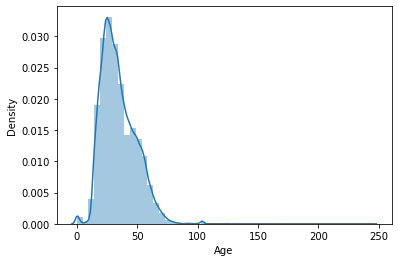

In [57]:
# Plotting Distribution of Age
sns.distplot(df_users['Age'].dropna())

Text(0.5, 1.0, 'Finding outlier data in Age column')

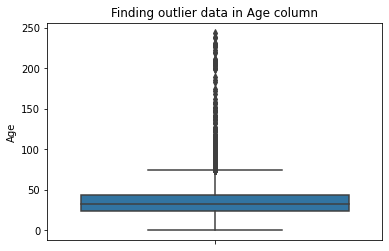

In [59]:
# checking outliers in Age column
sns.boxplot(y="Age", data=df_users)
plt.title('Finding outlier data in Age column')

We can easily see that not only Age column contains lot of null values but also ages that don't make much sense, we can't expect anyone to 250 years old and also there is no point that someone aged 0 would be reading books. We need proper treatment of the data.<BR>
For null values, present in Age, we will try to impute it with random values present that will be between median +- std deviation

In [69]:
# making outlier data present in Age column as nan
df_users.loc[(df_users.Age > 100) | (df_users.Age < 5), 'Age'] = np.nan

In [70]:
# Replacing null values in Age
median = df_users['Age'].median()
std = df_users['Age'].std()
random_age = np.random.randint(median - std, median + std, size = df_users.Age.isnull().sum())
age = df_users['Age'].copy()
age[pd.isnull(age)] = random_age
df_users['Age'] = age
df_users['Age'] = df_users['Age'].astype(int)

In [71]:
print("checking")
df_users.Age.isnull().sum()

checking


0

Text(0.5, 1.0, 'Finding outlier data in Age column')

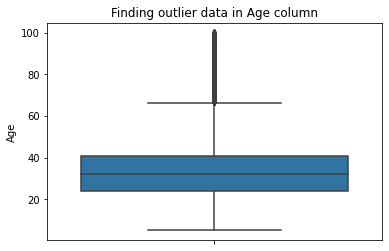

In [72]:
# checking outliers in Age column
sns.boxplot(y="Age", data=df_users)
plt.title('Finding outlier data in Age column')

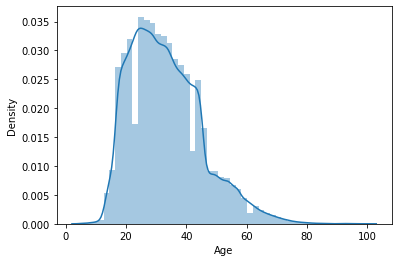

In [73]:
# Plotting Distribution of Age
sns.distplot(df_users['Age'])

## Ratings
Now we will try to check the rating provided by users for the books available

Text(0.5, 1.0, 'Total Ratings')

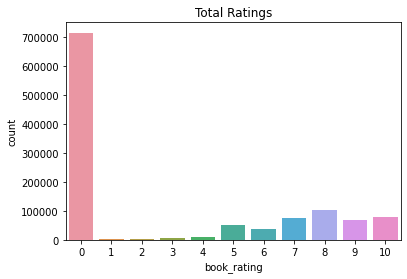

In [68]:
# count of ratings given
sns.countplot(x="book_rating",data=df_ratings)
plt.title("Total Ratings")

We can observe that over here, lot of 0 ratings are there. However, we know that ratings can only be between 1 to 10. <BR>
As per the problem statement, it was stated there are 2 types of ratings one is implicit ratings containing 0s and other is explicit ratings containing ratings between 1 to 10. <BR>
That means we need to consider different approaches for diffrent rating methodologies.

In [74]:
# seperating df_rating into 2 different dataframes
df_ratings_exp = df_ratings[df_ratings['book_rating']>=1]
df_ratings_imp = df_ratings[df_ratings['book_rating'] == 0]

In [75]:
df_ratings_exp.head()

,user_id,ISBN,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [76]:
df_ratings_imp.head()

,user_id,ISBN,book_rating
0,276725,034545104X,0
2,276727,0446520802,0
5,276733,2080674722,0
10,276746,0425115801,0
11,276746,0449006522,0
